# Prae-1 (EPIC 211916756) transit modelling

Prae-1 transit modelling assuming a Normal prior on logg with $\mu=4.5$, and $\sigma=0.5$.

In [1]:
%pylab inline
sys.path.append('../src')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tqdm import tqdm
from core import *

## Run DE and MCMC

The Differential Evolution optimization takes $\sim$30 seconds, and the MCMC sampling $\sim$25 minutes. Comment out the `do_mcmc = False` line to run the MCMC sampling.

In [3]:
npop, de_iter, mc_iter = 100, 200, 40000
lpf = LPFunction(logg_prior = NP(4.5, 0.5, 'logg', lims=(1,10)))
de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)

In [4]:
do_mcmc = True
do_mcmc = False

if do_mcmc:
    for r in tqdm(de(de_iter), total=de_iter): pass

    for i,r in enumerate(tqdm(sampler.sample(de.population, iterations=mc_iter, thin=100), total=mc_iter)):
        if ((i > 0) and (i%500 == 0)) or (i == mc_iter-1):
            savez('../results/02b', chains=sampler.chain)
            
chain = load('../results/02b.npz')['chains']
fc = chain[:,50:,:].reshape([-1,lpf.ps.ndim])
mp = median(fc, 0)

## Create the dataframe

In [5]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=lpf.ps.names)
df['tcc'] = df.tc - floor(df.tc.mean())
df['pc'] = df.p - 10
df['ecc'] = df.secw**2+df.sesw**2
df['w'] = arctan2(df.sesw, df.secw)/pi
df['e'] *= 1e6
df['k'] = sqrt(df.k2)
df['a'] = as_from_rhop(df.rho, df.p)
df['I'] = np.rad2deg(arccos(df.b/df.a))
df['u'] = 2*sqrt(df.q1)*df.q2
df['v'] = sqrt(df.q1)*(1-2*df.q2)
df['T14'] = 24*T14(df.p, df.a, df.k, radians(df.I))
df = df.drop(['k2','q1','q2'], axis=1)
df.describe()

,tc,p,rho,b,secw,sesw,e,c,tcc,pc,ecc,w,k,a,I,u,v,T14
count,35000.0000,35000.0000,35000.0000,3.5000e+04,35000.0000,35000.0000,35000.0000,3.5000e+04,35000.0000,35000.0000,3.5000e+04,35000.0000,35000.0000,35000.0000,35000.0000,35000.0000,35000.0000,35000.0000
mean,2317.8787,10.1344,5.6253,4.5607e-01,0.0097,-0.2851,937.4006,1.0001e+00,0.8787,0.1344,3.6533e-01,-0.2720,0.0790,30.0178,89.0467,0.9990,-0.2149,2.4848
std,0.0017,0.0005,3.3218,2.6831e-01,0.4144,0.3350,26.1115,3.8080e-05,0.0017,0.0005,2.3486e-01,0.4977,0.0089,6.2182,0.6802,0.4075,0.3789,0.5445
min,2317.8712,10.1326,0.3341,4.1998e-07,-0.7997,-0.8000,839.8037,9.9995e-01,0.8712,0.1326,3.1185e-06,-0.9999,0.0612,12.1965,85.7915,0.0001,-0.9899,1.3094
25%,2317.8776,10.1341,3.0832,2.2175e-01,-0.3324,-0.5546,919.7320,1.0001e+00,0.8776,0.1341,1.6751e-01,-0.6581,0.0730,25.5802,88.6140,0.7339,-0.4924,2.0799
50%,2317.8787,10.1344,4.9102,4.4907e-01,0.0132,-0.3437,936.8483,1.0001e+00,0.8787,0.1344,3.4113e-01,-0.3478,0.0766,29.8732,89.1676,1.0176,-0.2681,2.4707
75%,2317.8798,10.1347,7.4597,6.9136e-01,0.3543,-0.0485,954.8181,1.0002e+00,0.8798,0.1347,5.3944e-01,-0.0760,0.0832,34.3418,89.6004,1.2879,0.0186,2.8114
max,2317.8859,10.1364,14.9990,9.7322e-01,0.8000,0.7903,1049.9872,1.0003e+00,0.8859,0.1364,9.5691e-01,1.0000,0.1202,43.3456,90.0000,1.9895,0.9932,6.2236


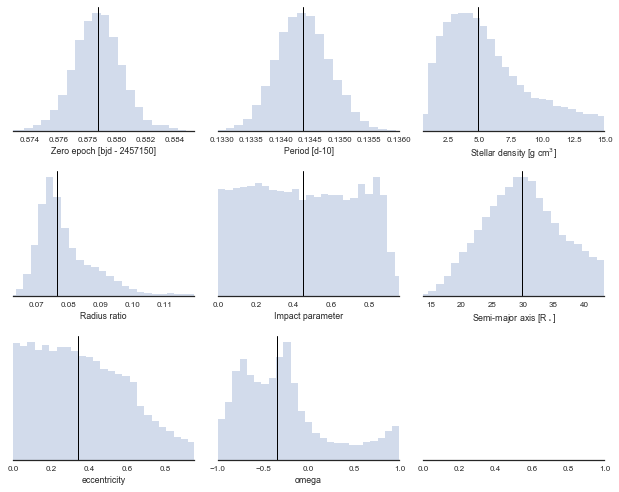

In [6]:
sb.set_context('paper')
fig,ax = subplots(3,3, figsize=(2.5*AAOCW,2*AAOCW))

pars = 'tcc pc rho k b a ecc w'.split()
labels = ('Zero epoch [bjd - {:7d}], Period [d-10], '
          'Stellar density [g cm$^3$], Radius ratio, '
          'Impact parameter, Semi-major axis [R$_\star$], eccentricity, omega'.format(bjdref+2317).split(', '))
             
for i,(par,label) in enumerate(zip(pars,labels)):
    df[par].hist(bins=25, normed=True, alpha=0.25, grid=False, ax=ax.flat[i])
    ax.flat[i].axvline(median(df[par]), c='k', lw=1)
    setp(ax.flat[i], xlabel=label, xlim=percentile(df[par], [0.05,99.95]))

sb.despine(fig, left=True)
setp(sum([a.get_yticklabels() for a in ax.flat]), visible=False)
fig.tight_layout()
#fig.savefig('basic_parameter_estimates_wn_crho4.png')

TypeError: slice indices must be integers or None or have an __index__ method

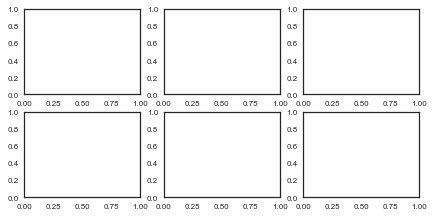

In [8]:
sb.set_context('paper')
fig,ax = subplots(2,3, figsize=(AAPGW,AAOCW))

pars = 'tcc pc rho k b a'.split()
labels = ('Zero epoch [BJD - {:7d}], Period [d-10], '
          'Stellar density [g cm$^3$], Radius ratio, '
          'Impact parameter, Semi-major axis [R$_\star$]'.format(bjdref+2317).split(', '))
             
for i,(par,label) in enumerate(zip(pars,labels)):
    sb.kdeplot(df[par], shade=True, ax=ax.flat[i], legend=False)
    #sb.kdeplot(dfb[par], shade=True, ax=ax.flat[i], legend=False)
    setp(ax.flat[i], xlabel=label, xlim=percentile(df[par], [0.05,99.95]))

sb.despine(fig, left=True)
setp(sum([a.get_yticklabels() for a in ax.flat]), visible=False)
setp(ax[0,0], xticks=linspace(0.875,0.882, 3))
setp(ax[0,2], xticks=linspace(1,6,6))
setp(ax[1,0], xticks=[0.065,0.075,0.085,0.095,0.105], xlim=(0.06,0.11))
setp(ax[1,1], xticks=linspace(0.,0.9,10))
setp(ax[1,2], xticks=linspace(15,33,7))
fig.tight_layout()
#fig.savefig('basic_parameter_estimates_wn_pub.pdf')

## Plot the light curve

In [9]:
pvs = permutation(fc)[:100]
time_m = linspace(mp[0]-0.03*mp[1], mp[0]+0.03*mp[1], 1500)
mphase_o_d = 24*mp[1]*(fold(lpf.time, mp[1], mp[0], 0.5, normalize=True) - 0.5)
mphase_m_d = 24*mp[1]*(fold(time_m,   mp[1], mp[0], 0.5, normalize=True) - 0.5)

flux_pr = array([lpf.compute_lc_model(pv, time_m) for pv in pvs])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
flux_mo = median(array([lpf.compute_lc_model(pv, time_m) for pv in pvs]), 0)

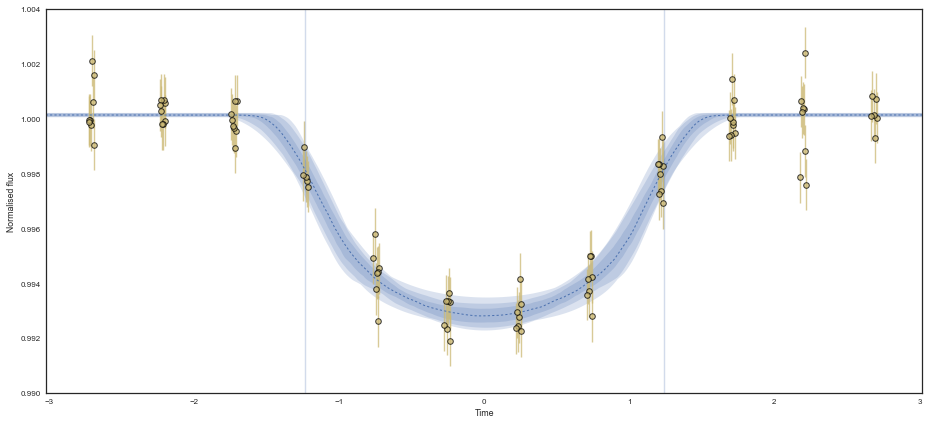

In [16]:
with sb.axes_style('white'):
    fig, ax = subplots(1,1, figsize=(13,6))
    hT14 = 0.5*median(df.T14)
    cp = sb.color_palette()
    sids = argsort(mphase_m_d)
    ax.errorbar(mphase_o_d, lpf.flux, mp[9], fmt='o', c=cp[4], alpha=0.75, markeredgecolor='k', markeredgewidth=1)
    [ax.fill_between(mphase_m_d[sids],*flux_pc[i:i+2,sids],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    ax.plot(mphase_m_d[sids], flux_pc[0,sids], c=cp[0], lw=1, ls=':')
    [ax.axvline(c*hT14, alpha=0.25) for c in [-1,1]]
    setp(ax, xlim=(-3.02,3.02), ylim=(0.99,1.004),xlabel='Time', ylabel='Normalised flux')
    fig.tight_layout()
    fig.savefig('lc_model_wn_crho4.png')

---

<center> &copy; 2017 Hannu Parviainen</center>